# Import packages and initalize

In [31]:
# Suppress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle
import calendar

# Path to data folder with provided material
data_path = '..//../'
# Set up some global variables 
prop_cycle = plt.rcParams['axes.prop_cycle']
color_list = prop_cycle.by_key()['color']

# Data input


## Frog data (response variable)
We use the functions included in the benchmark file to collect the frog data from the provided training data. We search for frogs in the 5 evaluation regions and an additional 4 regions on other parts of Australia's coast, limited to frogs observed between the start of 2015 and the present day. We do this by providing `year_range` and `bbox` parameters to the `get_frogs` function defined below.
The following cell is unmodified from the provided notebook, so we hide it.

In [2]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

Here we have modified the list of bboxs to contain the 5 from the submission file and four additional regions from other climates across Austrailia. 

In [3]:
bboxs=[
    # from submission file
    (144.8,-38.5,145.8,-37.5), 
    (150.7,-33.5,151.7,-32.5), 
    (152.6,-29.0,153.6,-28.0),
    (145.0,-17.7,146.0,-16.7),
    (115.7,-32.5,116.7,-31.5),
    # Additional regions
    (148.8, -35.7, 149.8, -34.7),
    (152.3, -30.7, 153.3, -29.7),
    (152.1, -27.3 , 153.1, -26.3),
    (130.8, -12.8, 131.8, -11.8),
    
]
    
# Load in data

frog_datas = []
for bbox in bboxs:
    frog_datas.append(get_frogs(data_path+'/training_data/occurrence.txt', 
                                year_range=(2015, 2022), bbox=bbox))

Annotate the frog data with 1 for target species, 0 for off-target species. 

In [7]:
target_species = 'Litoria Fallax'

for i, frog_data in enumerate(frog_datas):
    frog_datas[i] = (
        frog_data
        # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
        # as well as a key for joining (later)
        .assign(
            occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
        ).reset_index(drop=True)
        .assign(key=lambda x: x.index)
    )

## Weather data (predictor variable) 
We modified the `get_terraclimate` function from the benchmark file to group the weather data by month and take the maximum value, minimum value, mean, and standard deviation of each of our chosen measurements. 

In [5]:
def get_terraclimate_all(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Returns terraclimate data.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').compute()
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        data = data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return data

def get_terraclimate_months(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month."""
    ds = get_terraclimate_all(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    ds_month = [ds.groupby('time.month').max(dim='time'), 
                ds.groupby('time.month').min(dim='time'),
                ds.groupby('time.month').mean(dim='time'),
                ds.groupby('time.month').std(dim='time')]    
    return ds_month

def get_terraclimate(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month and make each month/asset a new variable."""
    ds_list = get_terraclimate_months(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    # hard code in labels for quantities. order is abritrary from get_terraclimate_months
    quantities = ['max','min','mean','std']

        # sets_list is a list of lists of datasets, each dataset has data for each metric/quantity pair
        # I need to unpack it twice. 
    sets_list = []
    for count, ds in enumerate(ds_list):
        sets = [
            ds.sel(month=month
                ).rename(
            {var: ' '.join((str(month), var, quantities[count])) for var in list(ds.keys())}
        ).drop_vars('month')
        for month in ds.month.values
        ]
        sets_list.append(sets)
    ds = xr.merge(
            # unpack each list in sets_list and merge into a larger dataset
        [xr.merge(sets_list[i]) for i in range(len(sets_list))]
            # merge these larger datasets into a dataset and
            # convert it into a data array, and rename the variable to band
        ).to_array().rename(variable='band')   
    return ds

We collect the weather data from January 2015 to December 2019, giving us 5 years worth of data for each region. We have selected to use the maximum air temperature, minimum air temperature, precipitation, and soil moisture content as the measurements in our model.

In [6]:
# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

interp_dims = (512, 512)

weather_datas = []
for bbox in bboxs:
    weather_datas.append(
        get_terraclimate(bbox, time_slice=time_slice, 
        assets=assets, interp_dims=interp_dims, verbose=True))

Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image


# Data preparation 

## Joining frogs to their climate data
We use the included function to join the frogs to their matching weather data. We iterate over the regions and then combine to make one large dataset containing frogs and weather from all 9 regions.

In [9]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,...,9 soil min,9 soil std,9 tmax max,9 tmax mean,9 tmax min,9 tmax std,9 tmin max,9 tmin mean,9 tmin min,9 tmin std
0,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0,0,...,58.0,64.724030,17.099998,16.540001,15.800003,0.535163,8.400002,7.180002,6.500000,0.652381
1,3384896595,2021-10-07 07:58:39,Australia,Australia,Victoria,-38.030947,145.432053,Crinia Signifera,0,1,...,133.0,58.321865,16.599998,16.080000,15.400002,0.526877,7.800003,6.600001,5.900002,0.648074
2,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0,2,...,98.0,69.232941,17.099998,16.620001,16.099998,0.396988,8.000000,6.720000,6.099998,0.661514
3,3463456499,2019-07-30 00:00:00,Australia,Australia,Victoria,-37.807553,145.263607,Crinia Signifera,0,3,...,80.0,42.371689,17.099998,16.480000,15.599998,0.620967,7.800003,6.560002,5.800003,0.671118
4,3463456516,2020-08-23 00:00:00,Australia,Australia,Victoria,-37.991842,145.118825,Crinia Signifera,0,4,...,18.0,37.986313,17.800003,17.160002,16.400002,0.595316,9.000000,7.740001,7.000000,0.674092


In [63]:
model_datas = []
for frog_data, weather_data in zip(frog_datas, weather_datas):    
    model_datas.append(join_frogs(frog_data, weather_data))

model_data = pd.concat(model_datas).dropna().reset_index(drop=True)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,...,9 soil min,9 soil std,9 tmax max,9 tmax mean,9 tmax min,9 tmax std,9 tmin max,9 tmin mean,9 tmin min,9 tmin std
0,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0,0,...,58.0,64.724030,17.099998,16.540001,15.800003,0.535163,8.400002,7.180002,6.500000,0.652381
1,3384896595,2021-10-07 07:58:39,Australia,Australia,Victoria,-38.030947,145.432053,Crinia Signifera,0,1,...,133.0,58.321865,16.599998,16.080000,15.400002,0.526877,7.800003,6.600001,5.900002,0.648074
2,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0,2,...,98.0,69.232941,17.099998,16.620001,16.099998,0.396988,8.000000,6.720000,6.099998,0.661514
3,3463456499,2019-07-30 00:00:00,Australia,Australia,Victoria,-37.807553,145.263607,Crinia Signifera,0,3,...,80.0,42.371689,17.099998,16.480000,15.599998,0.620967,7.800003,6.560002,5.800003,0.671118
4,3463456516,2020-08-23 00:00:00,Australia,Australia,Victoria,-37.991842,145.118825,Crinia Signifera,0,4,...,18.0,37.986313,17.800003,17.160002,16.400002,0.595316,9.000000,7.740001,7.000000,0.674092


## Downsampling data
Our training dataset contained 25,733 absence points and 13,839 presence points over all the geographical areas sampled, a nearly 2:1 imbalance.


In [64]:
model_data.value_counts('occurrenceStatus')

occurrenceStatus
0    25733
1    13839
dtype: int64

We developed a method to downsample the absences while preserving isolated ones, which may 
contain information that is not represented anywhere else. We searched each 1/24° by 
1/24° “pixel” (the TerraClimate resolution) in our regions of interest (ROI). Where there were multiple 
absences per pixel, we randomly selected one to keep, removing the rest. Because the number of 
kept absence points was less than the number of presence points, we randomly sampled from the 
pool of removed points, adding them back into the training set until the number of presence and 
absence points were equal, resulting in a dataset containing 13,839 presence points and 13,839 
absence points.

In [11]:
grid_size = 24

target_species_frog_data = model_data[model_data.occurrenceStatus == 1]

n = len(target_species_frog_data)

keep = pd.DataFrame(columns=model_data.columns)
to_downsample = pd.DataFrame(columns=model_data.columns)

non_target_species_frog_data = model_data[model_data.occurrenceStatus == 0]

for i in range(grid_size):
    for j in range(grid_size):
        for min_lon, min_lat, max_lon, max_lat in bboxs:
            non_target_frogs_in_pixel = non_target_species_frog_data.loc[
                (non_target_species_frog_data['decimalLatitude'] > min_lat + j/grid_size) & 
                (non_target_species_frog_data['decimalLatitude'] <= min_lat + (j+1)/grid_size) &
                (non_target_species_frog_data['decimalLongitude'] > min_lon + i/grid_size) &
                (non_target_species_frog_data['decimalLongitude'] <= min_lon + (i+1)/grid_size)
            ]
            if len(non_target_frogs_in_pixel) >= 1:
                keep_in_pixel = non_target_frogs_in_pixel.sample(1)
                keep = pd.concat((keep, keep_in_pixel))
                to_downsample = pd.concat((to_downsample, non_target_frogs_in_pixel.drop(keep_in_pixel.index)))

n_keep = len(keep)

if n_keep < n:
    keep = pd.concat((keep, to_downsample.sample(n - n_keep)))
    
model_data = (
    keep
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)

In [12]:
model_data.value_counts('occurrenceStatus')

occurrenceStatus
0    13839
1    13839
dtype: int64

We have downsampled our off-target data points so that our model data contains an equal number of target and off-target data points, while preserving the isolated instances off-target frogs.

Let's visualize the difference: 

In [13]:
def plot_frogs_comparison(bbox, frog_data, ds_data, title, xlim, ylim, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 2, figsize = (20, 10), sharex=True, sharey=True)
    extent = [bbox[0],bbox[2],bbox[1],bbox[3]]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('All frogs')
    x_ticks = np.arange(extent[0],extent[1]+1/24, 1/24)
    y_ticks = np.arange(extent[2],extent[3]+1/24, 1/24)
    ax[0].set_xticks([(extent[1]-extent[0])/2])
    ax[0].set_xticks(x_ticks, minor=True)
    ax[0].set_yticks([(extent[3]-extent[2])/2])
    ax[0].set_yticks(y_ticks, minor=True)
    ax[0].grid(which='both', alpha=0.5, c='black')
    
    ax[1].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[1], crs=crs)
    ax[1].set_title('Downsampled frogs')
    ax[1].set_xticks([(extent[1]-extent[0])/2])
    ax[1].set_xticks(x_ticks, minor=True)
    ax[1].set_yticks([(extent[3]-extent[2])/2])
    ax[1].set_yticks(y_ticks, minor=True)
    ax[1].grid(which='both', alpha=0.5, c='black')

    filt = frog_data.occurrenceStatus == 1
    ax[0].scatter(
        frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
        color = color_list[0], marker='o', s=100, alpha=1, label='Target Species'
    )
    non_target = frog_data.occurrenceStatus == 0
    ax[0].scatter(
        frog_data[non_target].decimalLongitude, frog_data[non_target].decimalLatitude, 
        color = color_list[1], marker='o',s=100, alpha=1, label='Off-Target Species'
    )
    ax[0].legend(loc = 'upper left')

    filt = ds_data.occurrenceStatus == 1
    ax[1].scatter(
        ds_data[filt].decimalLongitude, ds_data[filt].decimalLatitude, 
        color = color_list[0], marker='o', s=100, alpha=1, label='Target Species'
    )
    non_target = ds_data.occurrenceStatus == 0
    ax[1].scatter(
        ds_data[non_target].decimalLongitude, ds_data[non_target].decimalLatitude, 
        color = color_list[1], marker='o', s=100, alpha=1, label='Off-Target Species'
    )
    ax[1].legend(loc = 'upper left')
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)
    ax[0].set_xlim(xlim)
    ax[1].set_ylim(ylim)

    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    

A representative region of interest containing both the target frog species (blue) and off-target frog 
species (orange). Each 1/24° by 1/24° “pixel” (indicated by the gridlines) that contained off-target 
occurrences before downsampling retains at least one off-target occurrence after downsampling

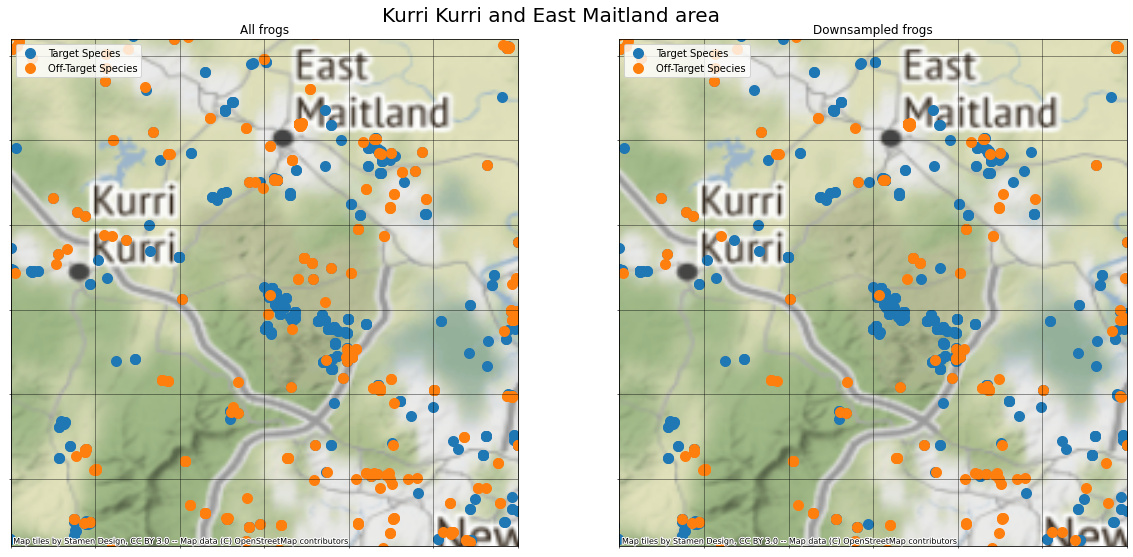

In [17]:
plot_frogs_comparison(bboxs[1], frog_datas[1], model_data,'Kurri Kurri and East Maitland area',(151.45,151.7),(-32.95,-32.7))


## Climate data
We chose to keep the climate data grouped by month to preserve the seasonal variations in our measures of maximum temperature, minimum temperature, preciptation, and soil moisture.  

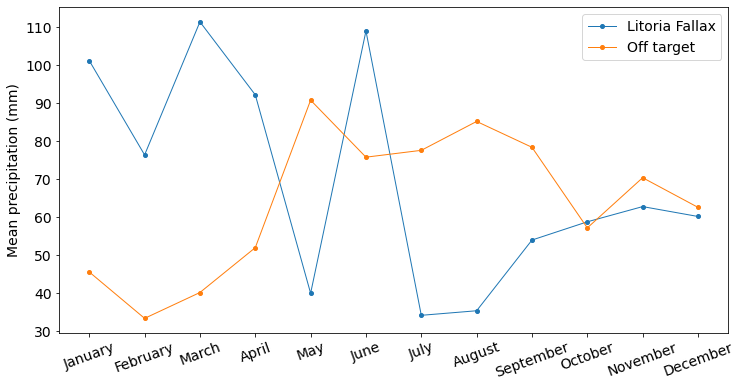

In [49]:
# sample randomly one 0 and one 1
random_LF = model_data[model_data.occurrenceStatus==1].sample(1, random_state=1)
random_off_target = model_data[model_data.occurrenceStatus==0].sample(1, random_state=1)
example_ppt = pd.concat([random_LF, random_off_target])
# drop non precipitation data 
ppt_mean_columns = []
for column in example_ppt.columns:
    if 'ppt mean' in column:
        ppt_mean_columns.append(column)
example_ppt = example_ppt[ppt_mean_columns]
# rearrange data into order by month.
# this uses hard indexing on the column number 
# so be careful to only evaulate this cell once...
example_ppt.insert(11, example_ppt.columns[1], example_ppt.pop(example_ppt.columns[1]))
example_ppt.insert(11, example_ppt.columns[1], example_ppt.pop(example_ppt.columns[1]))
example_ppt.insert(11, example_ppt.columns[1], example_ppt.pop(example_ppt.columns[1]))
# 
example_ppt_transpose = example_ppt.T
# plot
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(12, 6))
example_ppt_transpose[example_ppt_transpose.columns[0]].plot(marker='o',markersize=4,linewidth=1)
example_ppt_transpose[example_ppt_transpose.columns[1]].plot(marker='o',markersize=4,linewidth=1)
plt.legend([target_species,'Off target'])
#plt.title("Mean precipitation (mm)")
plt.ylabel("Mean precipitation (mm)")
plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=20)
plt.show()

Here's an example of the mean monthly 
precipitation over the 
timespan of 2015-2019 for an example off-target and on-target frog. We observe that this 
feature differ strongly in some parts of the year and are more similar from October to December, justifying keeping the monthly information.

# Model building
We chose to use a Random Forest Classifier model for this model. This gave us the most accurate predictions. 

In [50]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [51]:
full_model = make_pipeline(StandardScaler(), RandomForestClassifier())
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
y = model_data.occurrenceStatus.astype(int)

# Fit model
full_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

## Identify important columns 

In [71]:
importances = full_model['randomforestclassifier'].feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

In [74]:
forest_importances.nlargest(25)

1 ppt max       0.061517
1 ppt std       0.053337
9 tmax min      0.051930
3 ppt max       0.050440
10 tmax mean    0.036943
1 ppt mean      0.035204
1 soil std      0.031059
2 ppt max       0.024984
3 ppt mean      0.024843
9 tmax max      0.024654
2 ppt mean      0.024441
9 tmax mean     0.023670
2 ppt min       0.023142
3 ppt std       0.022780
3 soil max      0.020155
10 tmax min     0.018440
12 tmin min     0.017145
4 soil max      0.015906
8 tmax min      0.014865
11 tmin min     0.014853
1 tmin min      0.014743
1 tmin max      0.014738
1 tmin mean     0.014483
2 ppt std       0.013286
12 tmin std     0.010317
dtype: float64

This will actually change slightly every time I run the model because of the random nature of the random forest. I'm going to run it 10 times and sum the importances to get the most important ones

In [76]:
for i in range(10):
    full_model.fit(X, y)
    importances += full_model['randomforestclassifier'].feature_importances_
importances 

KeyboardInterrupt: 

In [78]:
forest_importances = pd.Series(importances, index=X.columns)
forest_importances.nlargest(25)

1 ppt std       0.440987
9 tmax min      0.433689
3 ppt max       0.406652
1 ppt max       0.368484
1 ppt mean      0.347920
2 ppt mean      0.326013
9 tmax max      0.308155
3 ppt mean      0.301517
2 ppt max       0.293077
3 ppt std       0.250946
9 tmax mean     0.249397
10 tmax mean    0.223539
4 soil max      0.210462
2 ppt min       0.183904
10 tmax min     0.179465
12 tmin min     0.172345
3 soil max      0.164786
1 tmin min      0.155879
1 tmin mean     0.148703
1 soil std      0.137156
8 tmax min      0.133375
1 tmin max      0.117421
12 tmin mean    0.108452
11 tmin min     0.101831
4 soil mean     0.100469
dtype: float64

In [80]:
forest_importances.nlargest(25).index

Index(['1 ppt std', '9 tmax min', '3 ppt max', '1 ppt max', '1 ppt mean',
       '2 ppt mean', '9 tmax max', '3 ppt mean', '2 ppt max', '3 ppt std',
       '9 tmax mean', '10 tmax mean', '4 soil max', '2 ppt min', '10 tmax min',
       '12 tmin min', '3 soil max', '1 tmin min', '1 tmin mean', '1 soil std',
       '8 tmax min', '1 tmin max', '12 tmin mean', '11 tmin min',
       '4 soil mean'],
      dtype='object')

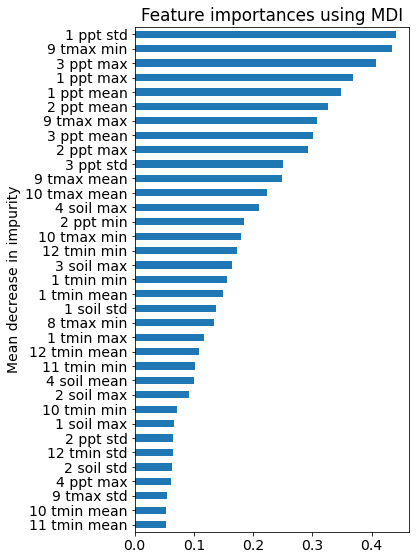

In [81]:
fig, ax = plt.subplots(figsize=(6,8))
forest_importances.nlargest(35)[::-1].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

I see a step change between "2 soil max" and "10 tmin min" which is at position 26. This is after all an arbitray choice but I'm going to see how it changes my performance.

In [83]:
keep_columns = forest_importances.nlargest(26).index

In [87]:
full_model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=420))
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
y = model_data.occurrenceStatus.astype(int)
X = X[list(keep_columns)]
# Fit model
full_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=420))])

Re-run evaluation metrics

In [89]:
in_sample_predictions = full_model.predict(X)

In [90]:
print("In sample "+f"F1 Score: {np.mean(f1_score(y, in_sample_predictions)).round(2)}")
print("In sample "+f"Accuracy: {np.mean(accuracy_score(y, in_sample_predictions)).round(2)}")

In sample F1 Score: 0.79
In sample Accuracy: 0.83


In [94]:
test_data = pd.concat(model_datas[0:5]).dropna().reset_index(drop=True)

In [95]:
test_X = (
    test_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
test_X = test_X[list(keep_columns)]
test_y = test_data.occurrenceStatus.astype(int)
out_of_sample_preds = full_model.predict(test_X)

In [98]:
print("Out of sample "+f"F1 Score: {np.mean(f1_score(test_y, out_of_sample_preds)).round(4)}")
print("Out of sample "+f"Accuracy: {np.mean(accuracy_score(test_y, out_of_sample_preds)).round(4)}")

Out of sample F1 Score: 0.7603
Out of sample Accuracy: 0.8055


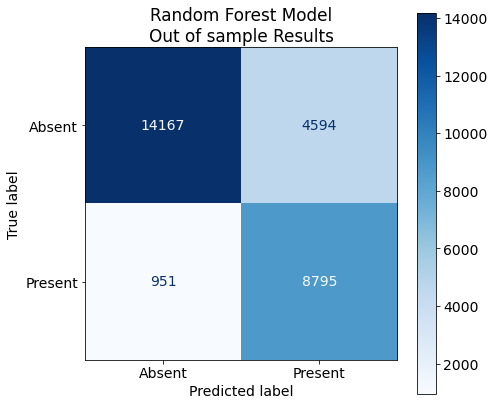

In [97]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, test_X, test_y,
                                             display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Random Forest Model\nOut of sample Results')
plt.show()

## Hyperparameter optimization
The built in functions for this task such as GridSearchCV kept crashing on my PC, so I wrote code to break the process into smaller parts and evaluated each individually. 

In [101]:
class_weight = ['balanced','balanced_subsample']
for i in class_weight:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(class_weight=i, random_state=420)).fit(X, y)
    predictions = a.predict(X)
    print('class_weight: '+i, f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


class_weight: balanced F1 Score: 0.7931
class_weight: balanced_subsample F1 Score: 0.7931


In [102]:
n_estimators = [10, 50, 100, 200, 300, 400]
for i in n_estimators:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=i,
                                                                random_state=420)).fit(X, y)
    predictions = a.predict(X)
    print("n_estimators: "+str(i), f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


n_estimators: 10 F1 Score: 0.7844
n_estimators: 50 F1 Score: 0.7835
n_estimators: 100 F1 Score: 0.7869
n_estimators: 200 F1 Score: 0.7871
n_estimators: 300 F1 Score: 0.7871
n_estimators: 400 F1 Score: 0.7872


In [110]:
max_features = [0.1,0.3,0.5,1,2]
for i in max_features:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(max_features=i,
                                                                random_state=420)).fit(X, y)
    predictions = a.predict(X)
    print("max_features: "+str(i), f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


max_features: 0.1 F1 Score: 0.7869
max_features: 0.3 F1 Score: 0.7869
max_features: 0.5 F1 Score: 0.7868
max_features: 1 F1 Score: 0.7868
max_features: 2 F1 Score: 0.7869


In [111]:
min_samples_split = [2, 5, 10, 15, 20, 30]
for i in min_samples_split:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(
        min_samples_split=i,
        #class_weight='balanced',
        n_estimators=200,
        random_state=420,
    )).fit(X, y)
    predictions = a.predict(X)
    print("min_samples_split: "+str(i), f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


min_samples_split: 2 F1 Score: 0.7871
min_samples_split: 5 F1 Score: 0.787
min_samples_split: 10 F1 Score: 0.787
min_samples_split: 15 F1 Score: 0.7867
min_samples_split: 20 F1 Score: 0.7866
min_samples_split: 30 F1 Score: 0.7865


In [113]:
n_estimators = [150, 200, 225]
for i in n_estimators:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(
        n_estimators=i,
        #class_weight='balanced',
        min_samples_split=2,
        random_state=420,
    )).fit(X,y)
    predictions = a.predict(X)
    print("n_estimators: "+str(i), f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


n_estimators: 150 F1 Score: 0.787
n_estimators: 200 F1 Score: 0.7871
n_estimators: 225 F1 Score: 0.7872


Re-evaluate the `class_weight` options with the refined values of `n_estimators` and `min_sample_split`.

In [114]:
class_weight = ['balanced','balanced_subsample']
for i in class_weight:
    a =  make_pipeline(StandardScaler(), RandomForestClassifier(
        n_estimators=225,
        class_weight=i,
        min_samples_split=2,
        random_state=420,
    )).fit(X,y)
    predictions = a.predict(X)
    print("class_weight: "+i, f"F1 Score: {np.mean(f1_score(y, predictions)).round(4)}")


class_weight: balanced F1 Score: 0.7931
class_weight: balanced_subsample F1 Score: 0.7931


## Model training
Using the hyperparameters determined from the above process, we train our model with the downsampled data.

In [115]:
full_model = make_pipeline(StandardScaler(), RandomForestClassifier(
        n_estimators=225,
        class_weight='balanced',
        min_samples_split=2,
        random_state=420,
    ))
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
y = model_data.occurrenceStatus.astype(int)
X = X[list(keep_columns)]

# Fit model
full_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=225, random_state=420))])

# Results on train/test data
## In-sample results
Predict the frogs in the training set from the weather data in the training set.

In [116]:
in_sample_predictions = full_model.predict(X)

In [117]:
print("In sample "+f"F1 Score: {np.mean(f1_score(y, in_sample_predictions)).round(2)}")
print("In sample "+f"Accuracy: {np.mean(accuracy_score(y, in_sample_predictions)).round(2)}")

In sample F1 Score: 0.79
In sample Accuracy: 0.83


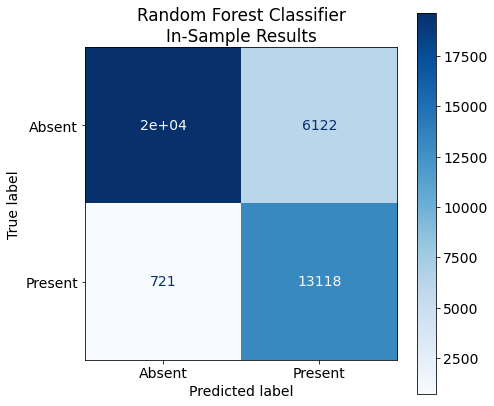

In [118]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Random Forest Classifier\nIn-Sample Results')
plt.show()

## Out-of-sample results
### Stratified k-fold cross validation

In [54]:
cv_model = full_model

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))


Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10


In [25]:
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")


Metrics averaged over 10 trials:
F1: 0.86
Accuracy: 0.85


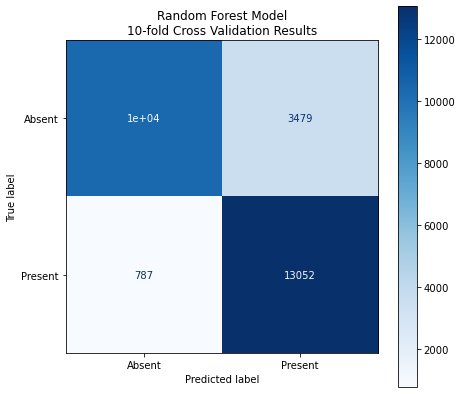

In [26]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Random Forest Model\n10-fold Cross Validation Results')
plt.show()

The stratified 10-fold cross-validation 
used the balanced dataset, but if the unseen data is unbalanced, the performance may decrease. 
Therefore, we also assessed out-of-sample performance by predicting the frogs from a nondownsampled dataset generated from the evaluation regions

### Evaluation regions dataset
Construct a testing dataset from the 5 evaluation regions with no down-sampling.

In [99]:
test_data = pd.concat(model_datas[0:5]).dropna().reset_index(drop=True)

In [119]:
test_X = (
    test_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
test_X = test_X[list(keep_columns)]
test_y = test_data.occurrenceStatus.astype(int)
out_of_sample_preds = full_model.predict(test_X)

### Evaluation regions dataset accuracy metrics

In [123]:
print("Out of sample "+f"F1 Score: {np.mean(f1_score(test_y, out_of_sample_preds)).round(2)}")
print("Out of sample "+f"Accuracy: {np.mean(accuracy_score(test_y, out_of_sample_preds)).round(2)}")

Out of sample F1 Score: 0.76
Out of sample Accuracy: 0.8


These predictions have an F1 score of 
0.76 / accuracy of 0.80. Looking at the confusion matrix, we observed that most of the 
test data are absences. The F1 score does not consider correctly identified negatives in its 
assessment, leading to the higher out-of-sample accuracy score (which considers true negatives 
and true positives) than out-of-sample F1 score.

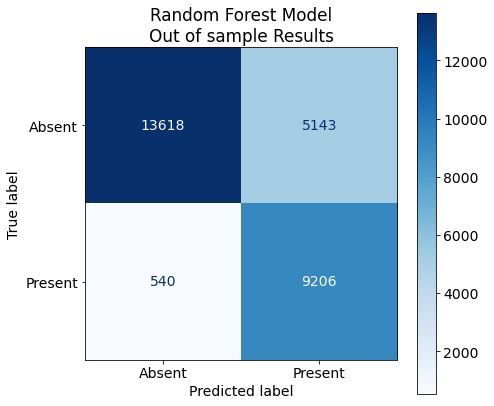

In [121]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, test_X, test_y,
                                             display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Random Forest Model\nOut of sample Results')
plt.show()

## NO change with top 26 features, going to try with fewer

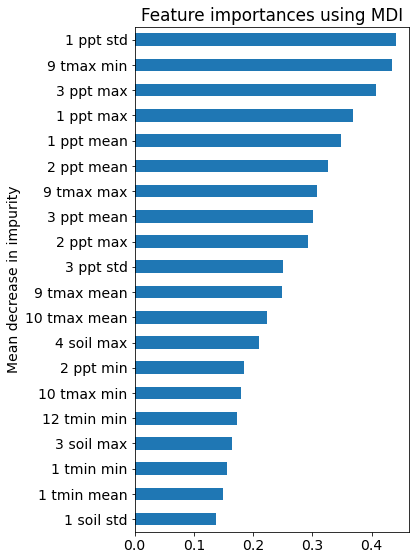

In [126]:
fig, ax = plt.subplots(figsize=(6,8))
forest_importances.nlargest(20)[::-1].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [129]:
keep_column forest_importances.nlargest(8).index

Index(['1 ppt std', '9 tmax min', '3 ppt max', '1 ppt max', '1 ppt mean',
       '2 ppt mean', '9 tmax max', '3 ppt mean'],
      dtype='object')

I see a step change between "2 soil max" and "10 tmin min" which is at position 26. This is after all an arbitray choice but I'm going to see how it changes my performance.

In [130]:
keep_columns = forest_importances.nlargest(8).index

In [131]:
full_model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=420))
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
y = model_data.occurrenceStatus.astype(int)
X = X[list(keep_columns)]
# Fit model
full_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=420))])

Re-run evaluation metrics

In [132]:
in_sample_predictions = full_model.predict(X)

In [133]:
print("In sample "+f"F1 Score: {np.mean(f1_score(y, in_sample_predictions)).round(2)}")
print("In sample "+f"Accuracy: {np.mean(accuracy_score(y, in_sample_predictions)).round(2)}")

In sample F1 Score: 0.79
In sample Accuracy: 0.83


In [134]:
test_data = pd.concat(model_datas[0:5]).dropna().reset_index(drop=True)

In [135]:
test_X = (
    test_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
test_X = test_X[list(keep_columns)]
test_y = test_data.occurrenceStatus.astype(int)
out_of_sample_preds = full_model.predict(test_X)

In [138]:
print("Out of sample "+f"F1 Score: {np.mean(f1_score(test_y, out_of_sample_preds)).round(4)}")
print("Out of sample "+f"Accuracy: {np.mean(accuracy_score(test_y, out_of_sample_preds)).round(4)}")

Out of sample F1 Score: 0.7602
Out of sample Accuracy: 0.8055


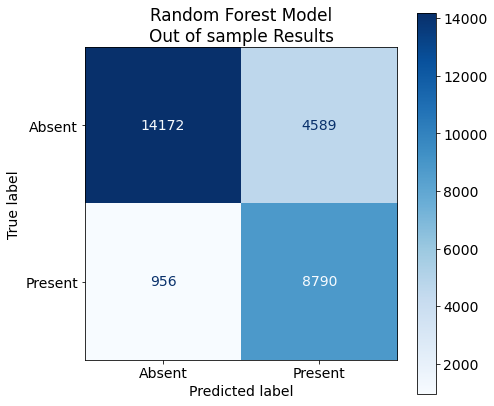

In [137]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, test_X, test_y,
                                             display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Random Forest Model\nOut of sample Results')
plt.show()

# Run the model
This is based on the guidelines for the competition, we made no changes to the code. 

In [58]:

def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
     # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [56]:
# Load in test coordinates
test_file = pd.read_csv('challenge_1_submission_template.csv')
# Read in test regions
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

Note: with the TerraClimate parameters we have set, some areas of each region contain nulls. If this is the case, the prediction will return a null, which evaluates to false when we create the binary mask.

The binary masks for each of the prediction regions are displayed below, as they are evaluated:

Loading data


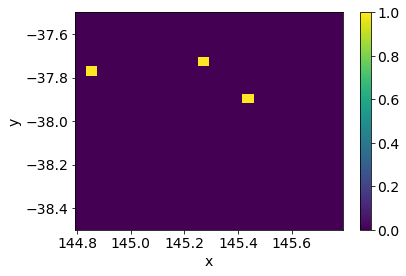

Loading data


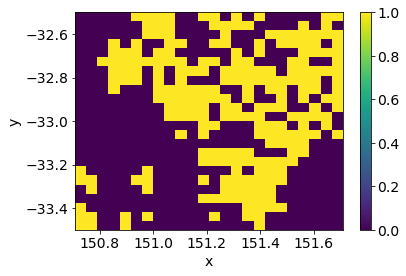

Loading data


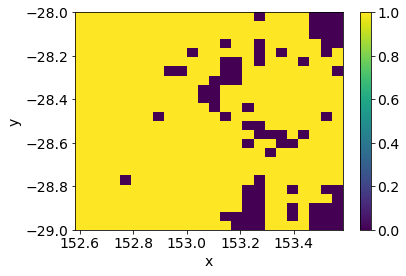

Loading data


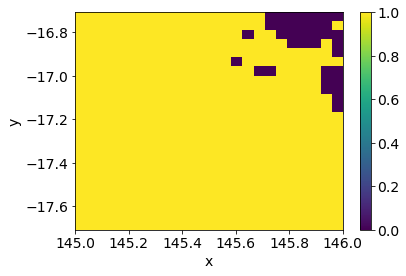

Loading data


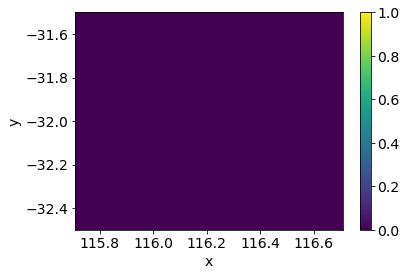

In [59]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], time_slice=time_slice, assets=assets)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    

We can now use these classification regions to assign predictions for each of the coordinates specified in the test file. We do this in a similar way to the `join_frogs` function we defined earlier, except in this case we are joining a prediction to each coordinate.


In [60]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)


What we are left with is a submission file with three columns: decimalLatitude, decimalLongitude, and occurrenceStatus. This is the file you will submit to the EY Data Science Challenge platform to receive your score on the leaderboard.

In [61]:
display(submission)

# Save to output folder
#submission.to_csv('challenge_1_submission_best_rerun_tidy.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,0
1,1,-37.770833,144.979167,0
2,2,-37.979167,145.354167,0
3,3,-37.604167,145.020833,0
4,4,-38.479167,145.645833,0
...,...,...,...,...
4046,4046,-31.895833,116.145833,0
4047,4047,-32.395833,115.770833,0
4048,4048,-32.145833,115.854167,0
4049,4049,-31.812500,116.229167,0
